# Practical 3: Full flexibility with QtPy

In Practical 2, we learned how to gain more control over the plugin appearance. Now, we will explore how to implement an image segmentation plugin in QtPy. 

## Load sample data

In [1]:
from skimage import data

nuclei_img = data.cells3d()[30,1]

## Defining functions

We will first define all the relevant functions (see Practical 2). Note that we are now importing the relevant packages within each function. This ensures that we only load packages that we will end up using.

In [70]:
import numpy as np 

def threshold_image(input_img: np.ndarray, threshold: float) -> np.ndarray:
    from skimage.util import img_as_float
    
    # Convert to float
    img = img_as_float(input_img)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

def apply_threshold_otsu(input_img: np.ndarray, nbins: int=256) -> np.ndarray:
    from skimage.util import img_as_float
    from skimage.filters import threshold_otsu
    
    # Convert to float
    img = img_as_float(input_img)
    # Obtain upper threshold value for each pixel
    threshold = threshold_otsu(img, nbins=nbins)
    # Apply thrshold
    thresh_img = img > threshold

    return thresh_img

def apply_cellpose(input_img: np.ndarray, use_gpu: bool=True) -> np.ndarray:
    from skimage.util import img_as_float
    from cellpose import models 
    
    # Convert to float
    img = img_as_float(input_img)

    # Instantiate Cellpose model
    model = models.CellposeModel(gpu=use_gpu)

    # Obtain Cellpose labels
    labels, __, __ = model.eval(img)

    return labels 

def segment_image(   
    input_img: 'napari.layers.Image',
    algorithm: str,
    threshold: float=0.2,
    nbins: int=256,
    use_gpu: bool=True
) -> 'napari.layers.Labels':

    from napari.layers import Labels

    if algorithm == 'Threshold':
        labels = threshold_image(input_img=input_img.data, 
                                 threshold=threshold)
    elif algorithm == 'Otsu':
        labels = apply_threshold_otsu(input_img=input_img.data,
                                      nbins=nbins)
    elif algorithm == 'Cellpose':
        labels = apply_cellpose(input_img=input_img.data,
                                use_gpu=use_gpu)

    return Labels(labels, name=f'{input_img.name}_{algorithm}')

## Building a widget with QtPy

We will start by building the outline of our plugin. First, we need to instantiate a `SegmentImage` class by subclassing `QWidget`. 

- For more information: [Python `class`](https://realpython.com/ref/glossary/class/), [Python `subclass`](https://realpython.com/ref/glossary/subclass/)

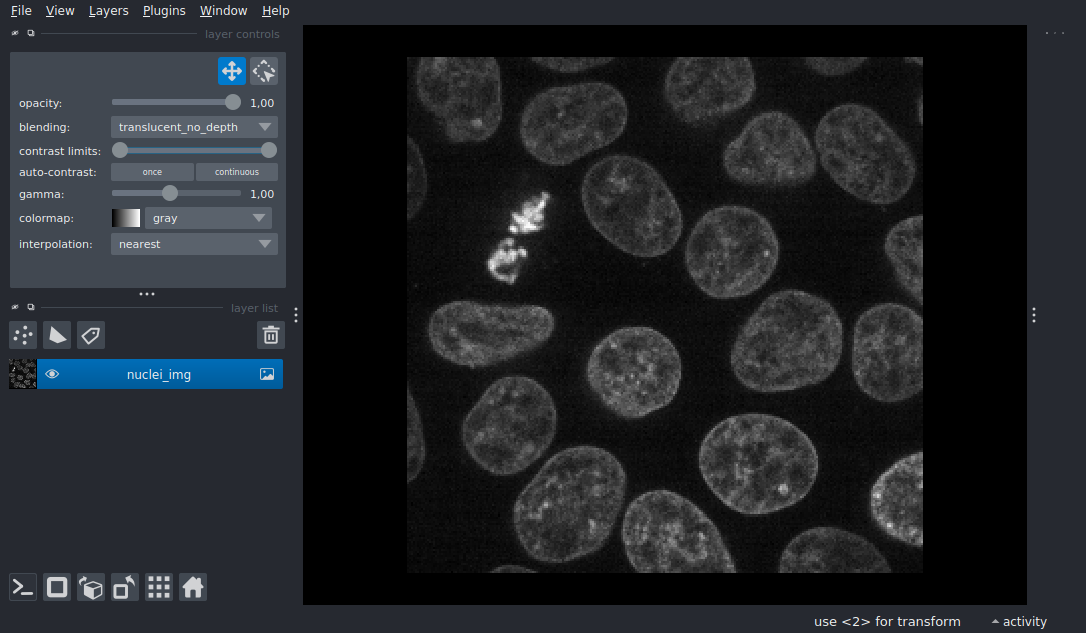

In [64]:
import napari
from qtpy.QtWidgets import QWidget

# SegmentImage is a subclass of QWdiget
class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        # Reuse the implementation of QWidget by calling super()
        super().__init__()

viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Selecting image layers

We will now add a `QComboBox` widget to select image layers directly from the viewer. We need to connect this widget to a function that keeps track of what image layers are actually availale in the napari viewer. We will solve this by defining the function `_update_combo_box`. We will also add a convenience function to retrieve the selected image layer which we will call `_get_selected_image_layer`.

- For more information: [The `self` argument in Python](https://realpython.com/ref/glossary/self/)

#### Define image layer widget in `__init__`:
Define a parent widget `layer_widget` and specify the layout as horizontal with `.setLayout(QHBoxLayout())`:
```python
layer_widget = QWidget()
layer_widget.setLayout(QHBoxLayout())
```
    
Add descriptive label with `QLabel`:
```python
layer_label = QLabel('Input image')
```

Add `QComboBox` to select an image layer. Enable access to the selected image layer throughout the `SegmentImage` class by adding `self.`:
```python
self._image_layers = QComboBox(self)        
```

Add widgets to `layer_widget` and then add the `layer_widget` to the main widget by calling `.layout().addWidget()`:
```python
layer_widget.layout().addWidget(layer_label)
layer_widget.layout().addWidget(self._image_layers)
self.layout().addWidget(layer_widget)
```

#### Define `_update_combo_box` function:
When we call the function `_update_combo_box`, we want to update the items (i.e. image layers) by first removing everything that has previously been stored:
```python
def _update_combo_box(self):
    for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
        layer_name_index = self._image_layers.findText(layer_name)
        self._image_layers.removeItem(layer_name_index)
```

Then, we access the list of layers in the napari viewer by calling `self.viewer.layers` and filter it for layers that are of the type `napari.layers.Image` with `isinstance(l, napari.layers.Image)`. Next, we need to add each image layer to the `QComboBox` by calling `.addItem()`:
```python
    for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
        if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            self._image_layers.addItem(layer.name)
```

To intitialise the image layer list in our `QComboBox`, we need to call the `_update_combo_box` function:
```python
self._update_combo_box()   

```

#### Define `_get_selected_image_layer` function:
Now, we will define a convenience function to easily retrieve the selecte image layer:
```python
def _get_selected_image_layer(self):
    return self.viewer.layers[self._image_layers.currentText()]
```

Let's add all of this to our `SelectImage` class and check that it works.

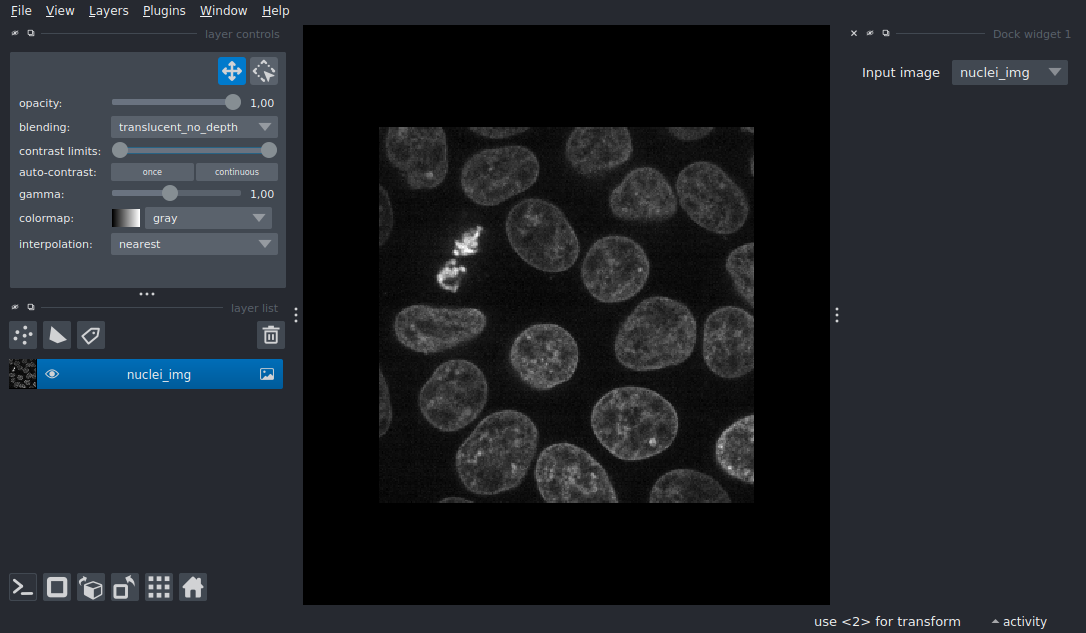

In [65]:
from qtpy.QtWidgets import (QWidget, QVBoxLayout, QHBoxLayout, QLabel, QComboBox)

class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer

        # Set widget layout
        self.setLayout(QVBoxLayout())
        
        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Input image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        self.layout().addWidget(layer_widget)

        # Update image layer combo box
        self._update_combo_box()   
            
    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]
        
viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Select segmentation algorithm

Next, we will add a `QComboBox` to select one of the three segmentation algorithms: "Threshold", "Otsu" and "Cellpose". 

#### Define algorithm widget in `__init__` function
First, define a parent widget `algo_widget` with a horizontal layout and then add a `QLabel` and a `QComboBox` widget to select the segmentation algorithm. Then, add these widgets by calling `.layout().addWidget()`:
```python
algo_widget = QWidget()
algo_widget.setLayout(QHBoxLayout())
algo_label = QLabel('Segmentation algorithm')
self._algorithm = QComboBox()
self._algorithm.addItems(['Threshold', 'Otsu', 'Cellpose'])
algo_widget.layout().addWidget(algo_label)
algo_widget.layout().addWidget(self._algorithm)
self.layout().addWidget(algo_widget)
```

Let's add this to our class and verify that it works.

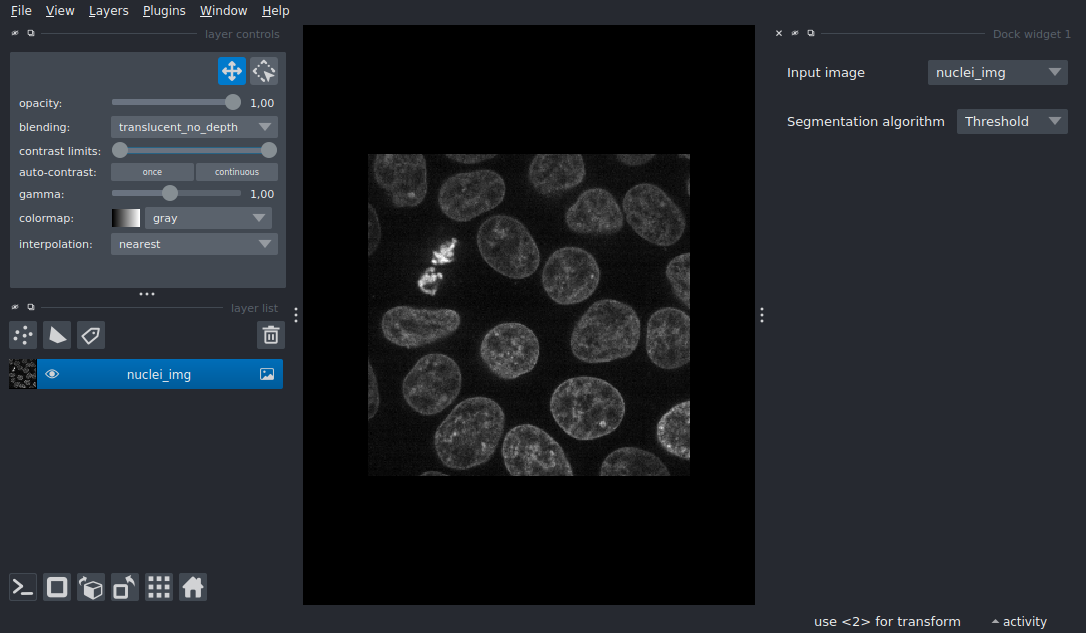

In [66]:
from qtpy.QtWidgets import (QWidget, QVBoxLayout, QHBoxLayout, QLabel, QComboBox)

class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer

        # Set widget layout
        self.setLayout(QVBoxLayout())
        
        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Input image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        self.layout().addWidget(layer_widget)

        # Select algorithm
        algo_widget = QWidget()
        algo_widget.setLayout(QHBoxLayout())
        algo_label = QLabel('Segmentation algorithm')
        self._algorithm = QComboBox()
        self._algorithm.addItems(['Threshold', 'Otsu', 'Cellpose'])
        algo_widget.layout().addWidget(algo_label)
        algo_widget.layout().addWidget(self._algorithm)
        self.layout().addWidget(algo_widget)
        
        # Update image layer combo box
        self._update_combo_box()   
            
    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]
        
viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Adding widgets for parameter selection 

Now, we will add widgets for each of the parameters using three different types of widgets: `QSlider`, `QSpinBox`, and `QCheckBox`. We will also connect our `QComboBox` to select the desired segmentation algorithm to the function `_update_parameters` that will toggle parameter visibility. 

#### Define the threshold widget
Define a parent widget with `QWidget`, a label with `QLabel` and then a slider to set the threshold with `QSlider`. Note that `QSlider` only supports integer value selection which we will overcome by adding another `QLabel` widget to display the selected threshold value. We will modify the displayed threshold value by connecting our `QSlider` widget to the function `_update_thresh_val` by calling `.valueChanged.connect()`:
```python
self.thresh_widget = QWidget()
self.thresh_widget.setLayout(QHBoxLayout())
thresh_label = QLabel('Threshold')
thresh_slider = QSlider(Qt.Orientation.Horizontal, minimum=0, maximum=100, value=20)
thresh_slider.valueChanged.connect(self._update_thresh_val)
self.thresh_val_label = QLabel('0.2')
```

Now, add each widget by calling `.layout().addWidget()`:
```python
self.thresh_widget.layout().addWidget(thresh_label)
self.thresh_widget.layout().addWidget(thresh_slider)
self.thresh_widget.layout().addWidget(self.thresh_val_label)
self.layout().addWidget(self.thresh_widget)
```

The function `_update_thresh_val` takes the selected threshold value from our `QSlider` widget (as integer values between 0 and 100) and divides it by 100 to obtain a `float`. It then updates the `QLabel` widget displaying the selected threshold value:
```python
def _update_thresh_val(self, val):
    self.thresh_val_label.setText(f'{val / 100}')
```

#### Define the nbins widget
Similarly to the threshold widget, define a parent widget with `QWidget` and add a descriptive label with `QLabel`. Instead of a slider, we use the `QSpinBox` widget.
```python
self.nbins_widget = QWidget()
self.nbins_widget.setLayout(QHBoxLayout())
nbins_label = QLabel('Number of bins')
self.nbins_spinbox = QSpinBox(minimum=1, maximum=256, value=256)
self.nbins_widget.layout().addWidget(nbins_label)
self.nbins_widget.layout().addWidget(self.nbins_spinbox)
self.layout().addWidget(self.nbins_widget)
```

#### Define the GPU widget
Here, we use a `QCheckBox`, since the choice of using a GPU or not is binary. We can define a preset value by calling `.setChecked()`:
```python
self.gpu_widget = QWidget()
self.gpu_widget.setLayout(QHBoxLayout())
gpu_label = QLabel('Use GPU')
self.gpu_checkbox = QCheckBox()
self.gpu_checkbox.setChecked(True)
self.gpu_widget.layout().addWidget(gpu_label)
self.gpu_widget.layout().addWidget(self.gpu_checkbox)
self.layout().addWidget(self.gpu_widget)
```

#### Updating parameter visibility
To toggle the visbility of the previously constructed parameter widgets, we define the function `_update_parameters`. We previously connected our `QComboBox` which selects the segmentation algorithm by calling `self._algorithm.activated.connect(self._update_parameters)`. To retrieve the currently selected segmentation algorithm, we call `.itemText()`. The visibility of each widget is changed by calling `.setVisible()`:
```python
def _update_parameters(self, index):
    algorithm = self._algorithm.itemText(index)

    if algorithm == 'Threshold':
        self.thresh_widget.setVisible(True)
        self.nbins_widget.setVisible(False)
        self.gpu_widget.setVisible(False)
        
    elif algorithm == 'Otsu':
        self.thresh_widget.setVisible(False)
        self.nbins_widget.setVisible(True)
        self.gpu_widget.setVisible(False)            

    elif algorithm == 'Cellpose':
        self.thresh_widget.setVisible(False)
        self.nbins_widget.setVisible(False)
        self.gpu_widget.setVisible(True)        
```

We then need to call the `_update_parameters` function to set the default visibility. Note that `index=0` corresponds to the first entry in the item list of the `QComboBox` widget, i.e. "Threshold":

```python
self._update_parameters(0)

```

Let's add all of this to our `SegmentImage` class and verify that it behaves as expected.

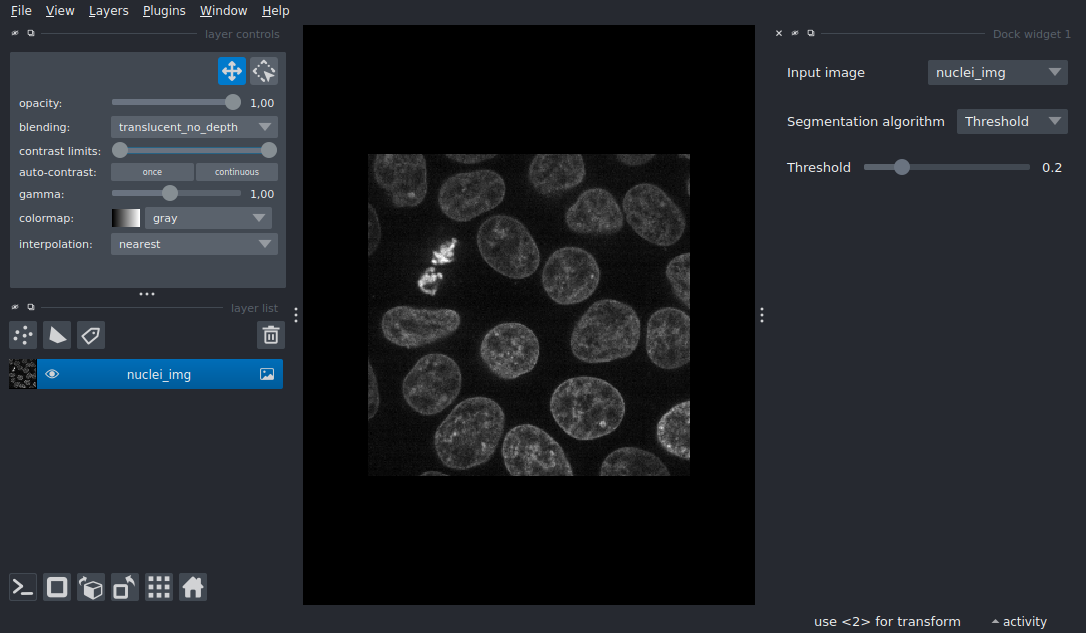

In [67]:
from qtpy.QtWidgets import (QWidget, QVBoxLayout, QHBoxLayout, QLabel, QSlider,
                            QComboBox, QPushButton, QCheckBox, QSpinBox)
from qtpy.QtGui import QPixmap
from qtpy.QtCore import Qt, QSize

class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer

        # Set widget layout
        self.setLayout(QVBoxLayout())

        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Input image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        self.layout().addWidget(layer_widget)

        # Select algorithm
        algo_widget = QWidget()
        algo_widget.setLayout(QHBoxLayout())
        algo_label = QLabel('Segmentation algorithm')
        self._algorithm = QComboBox()
        self._algorithm.addItems(['Threshold', 'Otsu', 'Cellpose'])
        self._algorithm.activated.connect(self._update_parameters)
        algo_widget.layout().addWidget(algo_label)
        algo_widget.layout().addWidget(self._algorithm)
        self.layout().addWidget(algo_widget)

        # Threshold parameter widget
        self.thresh_widget = QWidget()
        self.thresh_widget.setLayout(QHBoxLayout())
        thresh_label = QLabel('Threshold')
        thresh_slider = QSlider(Qt.Orientation.Horizontal, minimum=0, maximum=100, value=20)
        thresh_slider.valueChanged.connect(self._update_thresh_val)
        self.thresh_val_label = QLabel('0.2')
        self.thresh_widget.layout().addWidget(thresh_label)
        self.thresh_widget.layout().addWidget(thresh_slider)
        self.thresh_widget.layout().addWidget(self.thresh_val_label)
        self.layout().addWidget(self.thresh_widget)

        # nbins parameter widget
        self.nbins_widget = QWidget()
        self.nbins_widget.setLayout(QHBoxLayout())
        nbins_label = QLabel('Number of bins')
        self.nbins_spinbox = QSpinBox(minimum=1, maximum=256, value=256)
        self.nbins_widget.layout().addWidget(nbins_label)
        self.nbins_widget.layout().addWidget(self.nbins_spinbox)
        self.layout().addWidget(self.nbins_widget)

        # use_gpu parameter widget
        self.gpu_widget = QWidget()
        self.gpu_widget.setLayout(QHBoxLayout())
        gpu_label = QLabel('Use GPU')
        self.gpu_checkbox = QCheckBox()
        self.gpu_checkbox.setChecked(True)
        self.gpu_widget.layout().addWidget(gpu_label)
        self.gpu_widget.layout().addWidget(self.gpu_checkbox)
        self.layout().addWidget(self.gpu_widget)

        self._update_combo_box()
        self._update_parameters(0)
            
    def _update_thresh_val(self, val):
        self.thresh_val_label.setText(f'{val / 100}')
    
    def _update_parameters(self, index):
        algorithm = self._algorithm.itemText(index)

        if algorithm == 'Threshold':
            self.thresh_widget.setVisible(True)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(False)
            
        elif algorithm == 'Otsu':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(True)
            self.gpu_widget.setVisible(False)            

        elif algorithm == 'Cellpose':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(True)        
            
    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]

viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Adding a button to execute the plugin 

Finally, we will add a `QPushButton` so that we can run our plugin. We need to connect our button to a function that is executed when the button is clicked. For this, we will define the function `_run_segmentation`.

#### Define the button widget

Add a `QPushButton` widget and connect it to the `_run_segmentation` function:
```python
run_btn = QPushButton('Segment')
run_btn.clicked.connect(self._run_segmentation)
self.layout().addWidget(run_btn)
```

#### Define the `_run_segmentation` function

First, we need to retrieve all of the parameters from our paramter widgets:
```python
def _run_segmentation(self):
    input_img = self._get_selected_image_layer()
    algorithm = self._algorithm.currentText()
    threshold = float(self.thresh_val_label.text())
    nbins = self.nbins_spinbox.value()
    use_gpu = self.gpu_checkbox.isChecked()
```

Then, call the previously define `segment_image` function and pass all of the required parameters
```python
    labels = segment_image(input_img=input_img,
                           algorithm=algorithm,
                           threshold=threshold,
                           nbins=nbins,
                           use_gpu=use_gpu)
```
Finally, add the labels layer to the napari viewer:
```python
    self.viewer.add_layer(labels)
```

Let's add this to our class and check if we can obtain segmentations with our plugin!

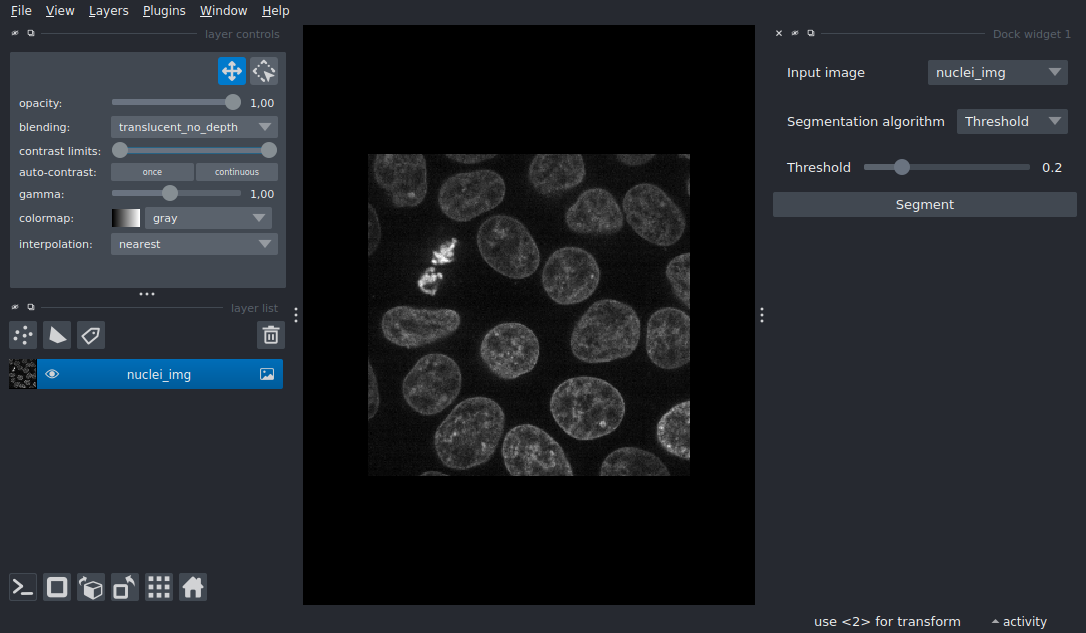

In [68]:
from qtpy.QtWidgets import (QWidget, QVBoxLayout, QHBoxLayout, QLabel, QSlider,
                            QComboBox, QPushButton, QCheckBox, QSpinBox)
from qtpy.QtGui import QPixmap
from qtpy.QtCore import Qt, QSize

class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer

        # Set widget layout
        self.setLayout(QVBoxLayout())

        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Input image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        self.layout().addWidget(layer_widget)

        # Select algorithm
        algo_widget = QWidget()
        algo_widget.setLayout(QHBoxLayout())
        algo_label = QLabel('Segmentation algorithm')
        self._algorithm = QComboBox()
        self._algorithm.addItems(['Threshold', 'Otsu', 'Cellpose'])
        self._algorithm.activated.connect(self._update_parameters)
        algo_widget.layout().addWidget(algo_label)
        algo_widget.layout().addWidget(self._algorithm)
        self.layout().addWidget(algo_widget)

        # Threshold parameter widget
        self.thresh_widget = QWidget()
        self.thresh_widget.setLayout(QHBoxLayout())
        thresh_label = QLabel('Threshold')
        thresh_slider = QSlider(Qt.Orientation.Horizontal, minimum=0, maximum=100, value=20)
        thresh_slider.valueChanged.connect(self._update_thresh_val)
        self.thresh_val_label = QLabel('0.2')
        self.thresh_widget.layout().addWidget(thresh_label)
        self.thresh_widget.layout().addWidget(thresh_slider)
        self.thresh_widget.layout().addWidget(self.thresh_val_label)
        self.layout().addWidget(self.thresh_widget)

        # nbins parameter widget
        self.nbins_widget = QWidget()
        self.nbins_widget.setLayout(QHBoxLayout())
        nbins_label = QLabel('Number of bins')
        self.nbins_spinbox = QSpinBox(minimum=1, maximum=256, value=256)
        self.nbins_widget.layout().addWidget(nbins_label)
        self.nbins_widget.layout().addWidget(self.nbins_spinbox)
        self.layout().addWidget(self.nbins_widget)

        # use_gpu parameter widget
        self.gpu_widget = QWidget()
        self.gpu_widget.setLayout(QHBoxLayout())
        gpu_label = QLabel('Use GPU')
        self.gpu_checkbox = QCheckBox()
        self.gpu_checkbox.setChecked(True)
        self.gpu_widget.layout().addWidget(gpu_label)
        self.gpu_widget.layout().addWidget(self.gpu_checkbox)
        self.layout().addWidget(self.gpu_widget)
        
        # Run plugin
        run_btn = QPushButton('Segment')
        run_btn.clicked.connect(self._run_segmentation)
        self.layout().addWidget(run_btn)

        self._update_combo_box()
        self._update_parameters(0)
            
    def _update_thresh_val(self, val):
        self.thresh_val_label.setText(f'{val / 100}')
    
    def _update_parameters(self, index):
        algorithm = self._algorithm.itemText(index)

        if algorithm == 'Threshold':
            self.thresh_widget.setVisible(True)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(False)
            
        elif algorithm == 'Otsu':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(True)
            self.gpu_widget.setVisible(False)            

        elif algorithm == 'Cellpose':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(True)        
            
    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]
    
    def _run_segmentation(self):
        input_img = self._get_selected_image_layer()
        algorithm = self._algorithm.currentText()
        threshold = float(self.thresh_val_label.text())
        nbins = self.nbins_spinbox.value()
        use_gpu = self.gpu_checkbox.isChecked()

        labels = segment_image(input_img=input_img,
                               algorithm=algorithm,
                               threshold=threshold,
                               nbins=nbins,
                               use_gpu=use_gpu)
        
        self.viewer.add_layer(labels)

viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Bonus: Adding a logo

An important benefit of using `QtPy` is added flexibility. For example, we can use `QPixmap` to to add a logo to our plugin. 

#### Define a parent widget

First, we need to define a parent widget with `QWidget` in our `__init__` function:

```python
logo_widget = QWidget()
logo_widget.setLayout(QHBoxLayout())
```
We can then load an image from a defined filepath using `QPixmap`. The size of our logo will be defined with `QSize`. We can then scale our logo image by calling `.scaled()`. Here, we can also define additional parameters like `Qt.KeepAspectRatio`:
```python
logo_path = 'institut_pasteur_logo.jpg'
logo_img = QPixmap(logo_path)
logo_size_inner = QSize(220, 70)
logo_size_outer = QSize(230, 80)
logo_img = logo_img.scaled(logo_size_inner, Qt.KeepAspectRatio, transformMode=Qt.SmoothTransformation)
```

Finally, we can add our logo to our main widget as a `QLabel` by calling `.setPixmap()`. We also have to define the size of our label and finally add everything to our main widget by calling `.layout().addWidget()`: 

```python
logo_label = QLabel()
logo_label.setPixmap(logo_img)
logo_label.setFixedSize(logo_size_outer.width(), logo_size_outer.height())
logo_widget.layout().addWidget(logo_label)
self.layout().addWidget(logo_widget)
```

Let's add this to our plugin and check out our logo.

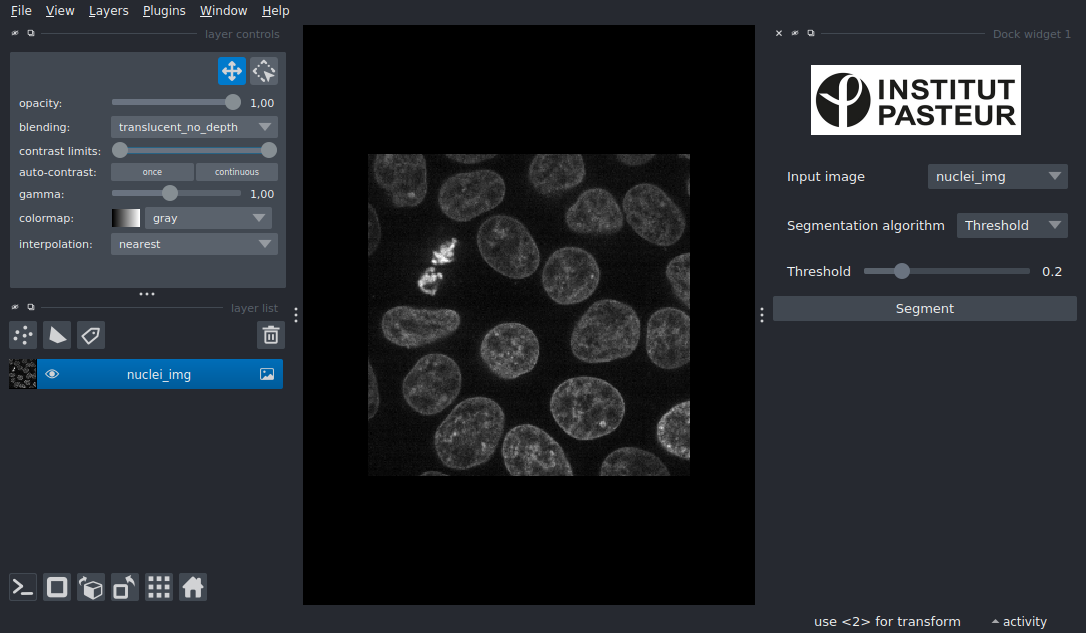

In [69]:
from qtpy.QtWidgets import (QWidget, QVBoxLayout, QHBoxLayout, QLabel, QSlider,
                            QComboBox, QPushButton, QCheckBox, QSpinBox)
from qtpy.QtGui import QPixmap
from qtpy.QtCore import Qt, QSize

class SegmentImage(QWidget):
    def __init__(self, napari_viewer='napari.viewer.Viewer'):
        super().__init__()
        self.viewer = napari_viewer

        # Set widget layout
        self.setLayout(QVBoxLayout())

        # Add logo
        logo_widget = QWidget()
        logo_widget.setLayout(QHBoxLayout())
        logo_path = 'institut_pasteur_logo.jpg'
        logo_img = QPixmap(logo_path)
        logo_size_inner = QSize(220, 70)
        logo_size_outer = QSize(230, 80)
        logo_img = logo_img.scaled(logo_size_inner, Qt.KeepAspectRatio, transformMode=Qt.SmoothTransformation)
        logo_label = QLabel()
        logo_label.setPixmap(logo_img)
        logo_label.setFixedSize(logo_size_outer.width(), logo_size_outer.height())
        logo_widget.layout().addWidget(logo_label)
        self.layout().addWidget(logo_widget)
        
        # Select image layer
        layer_widget = QWidget()
        layer_widget.setLayout(QHBoxLayout())
        layer_label = QLabel('Input image')
        self._image_layers = QComboBox(self)        
        layer_widget.layout().addWidget(layer_label)
        layer_widget.layout().addWidget(self._image_layers)
        self.layout().addWidget(layer_widget)

        # Select algorithm
        algo_widget = QWidget()
        algo_widget.setLayout(QHBoxLayout())
        algo_label = QLabel('Segmentation algorithm')
        self._algorithm = QComboBox()
        self._algorithm.addItems(['Threshold', 'Otsu', 'Cellpose'])
        self._algorithm.activated.connect(self._update_parameters)
        algo_widget.layout().addWidget(algo_label)
        algo_widget.layout().addWidget(self._algorithm)
        self.layout().addWidget(algo_widget)

        # Threshold parameter widget
        self.thresh_widget = QWidget()
        self.thresh_widget.setLayout(QHBoxLayout())
        thresh_label = QLabel('Threshold')
        thresh_slider = QSlider(Qt.Orientation.Horizontal, minimum=0, maximum=100, value=20)
        thresh_slider.valueChanged.connect(self._update_thresh_val)
        self.thresh_val_label = QLabel('0.2')
        self.thresh_widget.layout().addWidget(thresh_label)
        self.thresh_widget.layout().addWidget(thresh_slider)
        self.thresh_widget.layout().addWidget(self.thresh_val_label)
        self.layout().addWidget(self.thresh_widget)

        # nbins parameter widget
        self.nbins_widget = QWidget()
        self.nbins_widget.setLayout(QHBoxLayout())
        nbins_label = QLabel('Number of bins')
        self.nbins_spinbox = QSpinBox(minimum=1, maximum=256, value=256)
        self.nbins_widget.layout().addWidget(nbins_label)
        self.nbins_widget.layout().addWidget(self.nbins_spinbox)
        self.layout().addWidget(self.nbins_widget)

        # use_gpu parameter widget
        self.gpu_widget = QWidget()
        self.gpu_widget.setLayout(QHBoxLayout())
        gpu_label = QLabel('Use GPU')
        self.gpu_checkbox = QCheckBox()
        self.gpu_checkbox.setChecked(True)
        self.gpu_widget.layout().addWidget(gpu_label)
        self.gpu_widget.layout().addWidget(self.gpu_checkbox)
        self.layout().addWidget(self.gpu_widget)
        
        # Run plugin
        run_btn = QPushButton('Segment')
        run_btn.clicked.connect(self._run_segmentation)
        self.layout().addWidget(run_btn)

        self._update_combo_box()
        self._update_parameters(0)
            
    def _update_thresh_val(self, val):
        self.thresh_val_label.setText(f'{val / 100}')
    
    def _update_parameters(self, index):
        algorithm = self._algorithm.itemText(index)

        if algorithm == 'Threshold':
            self.thresh_widget.setVisible(True)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(False)
            
        elif algorithm == 'Otsu':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(True)
            self.gpu_widget.setVisible(False)            

        elif algorithm == 'Cellpose':
            self.thresh_widget.setVisible(False)
            self.nbins_widget.setVisible(False)
            self.gpu_widget.setVisible(True)        
            
    def _update_combo_box(self):
        for layer_name in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
            layer_name_index = self._image_layers.findText(layer_name)
            self._image_layers.removeItem(layer_name_index)

        for layer in [l for l in self.viewer.layers if isinstance(l, napari.layers.Image)]:
            if layer.name not in [self._image_layers.itemText(i) for i in range(self._image_layers.count())]:
                self._image_layers.addItem(layer.name)

    def _get_selected_image_layer(self):
        return self.viewer.layers[self._image_layers.currentText()]
    
    def _run_segmentation(self):
        input_img = self._get_selected_image_layer()
        algorithm = self._algorithm.currentText()
        threshold = float(self.thresh_val_label.text())
        nbins = self.nbins_spinbox.value()
        use_gpu = self.gpu_checkbox.isChecked()

        labels = segment_image(input_img=input_img,
                               algorithm=algorithm,
                               threshold=threshold,
                               nbins=nbins,
                               use_gpu=use_gpu)
        
        self.viewer.add_layer(labels)

viewer = napari.view_image(nuclei_img)
widget = SegmentImage(napari_viewer=viewer)
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)